# Imports

In [513]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, train_test_split

import warnings
warnings.filterwarnings("ignore")

# Loading Dataset

In [514]:
import os
import kagglehub

# Download the dataset (it will go to cache)
path = kagglehub.dataset_download("berkerisen/wind-turbine-scada-dataset")

print("Dataset downloaded to:", path)

# List files in the directory
files = os.listdir(path)
print("Files in dataset:", files)

# Read the CSV file
csv_files = [f for f in files if f.endswith('.csv')]

if csv_files:
    csv_path = os.path.join(path, csv_files[0])
    df = pd.read_csv(csv_path)
    print(f"\nLoaded: {csv_files[0]}")
else:
    raise FileNotFoundError("No CSV file found in the dataset")

Dataset downloaded to: C:\Users\User\.cache\kagglehub\datasets\berkerisen\wind-turbine-scada-dataset\versions\3
Files in dataset: ['T1.csv']

Loaded: T1.csv


In [515]:
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [516]:
df.index = pd.to_datetime(df['Date/Time'],format='%d %m %Y %H:%M')
df.sort_index(inplace=True)
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,,
2018-01-01 00:00:00,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
2018-01-01 00:30:00,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
2018-01-01 00:40:00,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


# Descriptive Statistics

In [517]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50530 entries, 2018-01-01 00:00:00 to 2018-12-31 23:50:00
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 2.3+ MB


In [518]:
df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


There are negative values for LV Active Power feature, need to investigate further the validity of this measurements, two scenarios:
* Wind speed is low -> blades are not spinning and turbine is consuming electricity
* Wind speed is high -> blades are spinning and probably a sensor malfunction

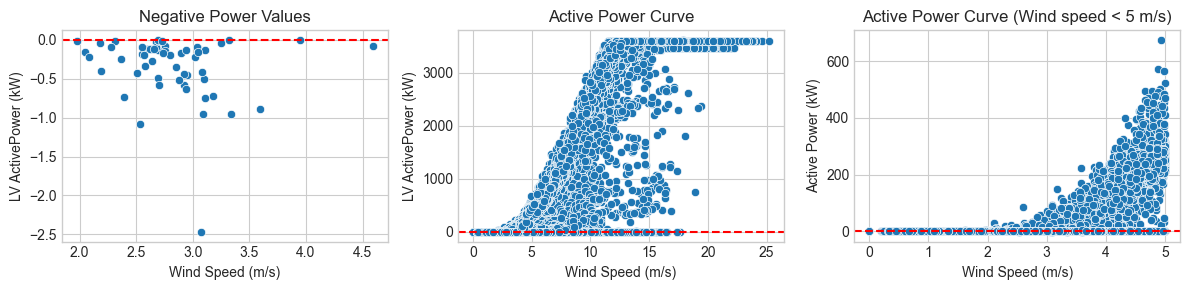

In [519]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
sns.scatterplot(data=df[df['LV ActivePower (kW)'] < 0], x='Wind Speed (m/s)', y='LV ActivePower (kW)', ax=ax[0])
ax[0].set_title('Negative Power Values')
ax[0].axhline(0, color='red', linestyle='--')

sns.scatterplot(data=df, x='Wind Speed (m/s)', y='LV ActivePower (kW)', ax=ax[1])
ax[1].set_title('Active Power Curve')
ax[1].axhline(0, color='red', linestyle='--')

sns.scatterplot(data=df[df['Wind Speed (m/s)'] < 5], x='Wind Speed (m/s)', y='LV ActivePower (kW)', ax=ax[2])
ax[2].set_title('Active Power Curve (Wind speed < 5 m/s)')
ax[2].axhline(0, color='red', linestyle='--')

plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Active Power (kW)")
plt.legend()
plt.tight_layout()
plt.show()

We can observe that most of the negative values occur bellow the 3.5 m/s wind speed, we conclude that it is most probably not sensor malfunction and that the turbine is truly consuming more energy than it generates.

# Handling Outliers

Since we are predicting the power generation output, negative values in Active Power act as noise for the model, therefore they need to be handled. In this case we set them to zero because for power production forecasting, a negative value is effectively zero power generated.

In [520]:
negative_values = (df['LV ActivePower (kW)'] < 0).sum()
print('Negative values in LV ActivePower (kW):',negative_values)

Negative values in LV ActivePower (kW): 57


In [521]:
df.loc[df['LV ActivePower (kW)'] < 0, 'LV ActivePower (kW)'] = 0

# Feature Engineering

## Feature Extraction

In [522]:
#Converting to pandas date time
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format ='%d %m %Y %H:%M')

In [523]:
#Extracting month
df['Month'] = df['Date/Time'].dt.month

In [524]:
#Extracting season
seasons_dict = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}
df['Season'] = df['Month'].map(seasons_dict)

In [525]:
#Extracting night or day
df['night_or_day'] = np.where(
    (df['Date/Time'].dt.hour < 6) | (df['Date/Time'].dt.hour >= 18),
    'night',
    'day'
)

In [526]:
#Extracting day of month
df['Day'] = df['Date/Time'].dt.day

In [527]:
#Extracting hour
df['Hour']=df['Date/Time'].dt.hour

In [528]:
#Extracting minutes
df['Minute']=df['Date/Time'].dt.minute

In [529]:
#Feature extraction completed: dropping date time column
df.drop(columns=['Date/Time'], inplace=True)
#Checking for missing values
df.isna().sum()

LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
Month                            0
Season                           0
night_or_day                     0
Day                              0
Hour                             0
Minute                           0
dtype: int64

# Exploratory Data Analysis

In [530]:
# Numerical and Date Columns
date_col = ['Month','Season','night_or_day','Day','Hour', 'Minute']
num_col = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']

## Univariate Analysis

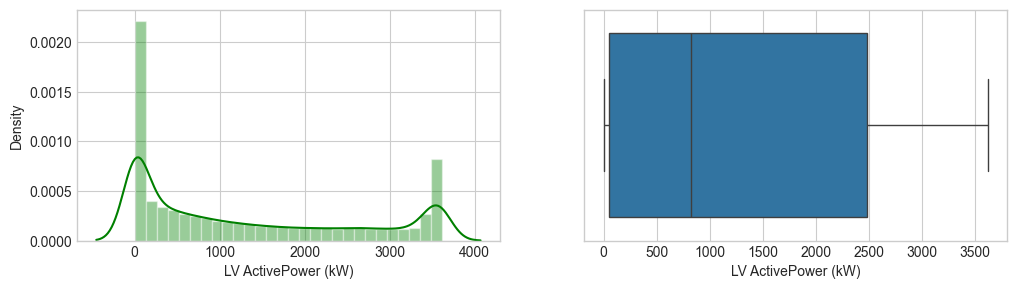

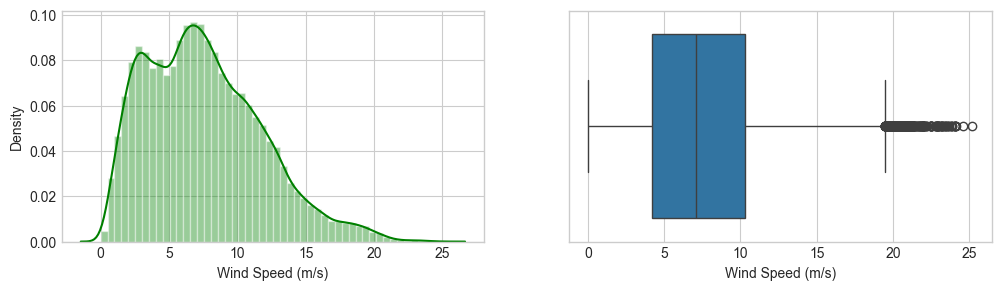

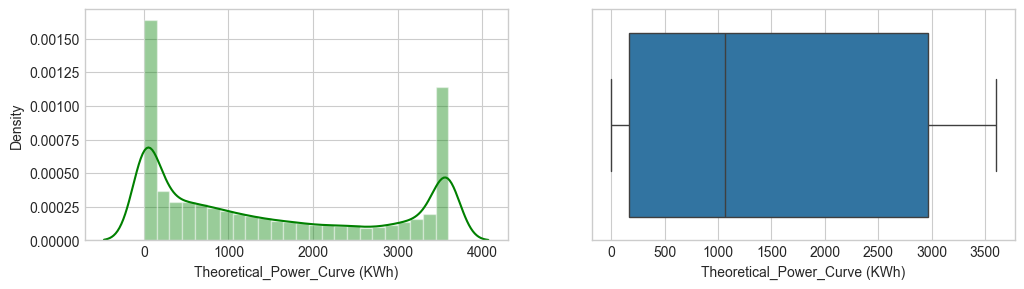

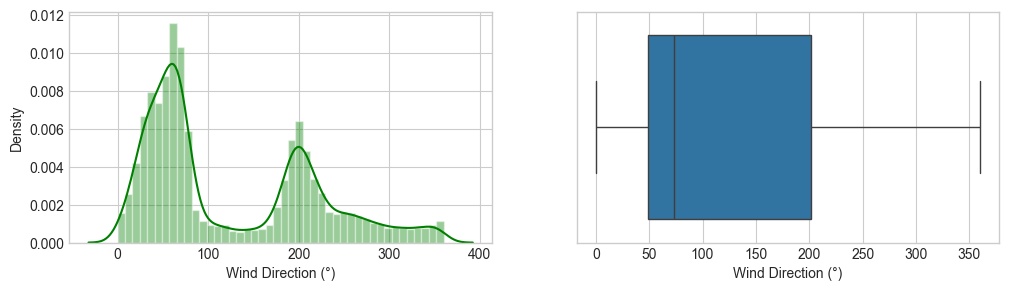

In [531]:
for col in num_col:
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    sns.distplot(df[col], ax=ax[0] ,color='green')
    sns.boxplot(x=df[col], ax=ax[1])
    plt.show()

We can find a bimodal distribution in wind direction data representing the prevailing wind direction or the two most common directions the wind blows at that specific turbine location.

## Bivariate Analysis

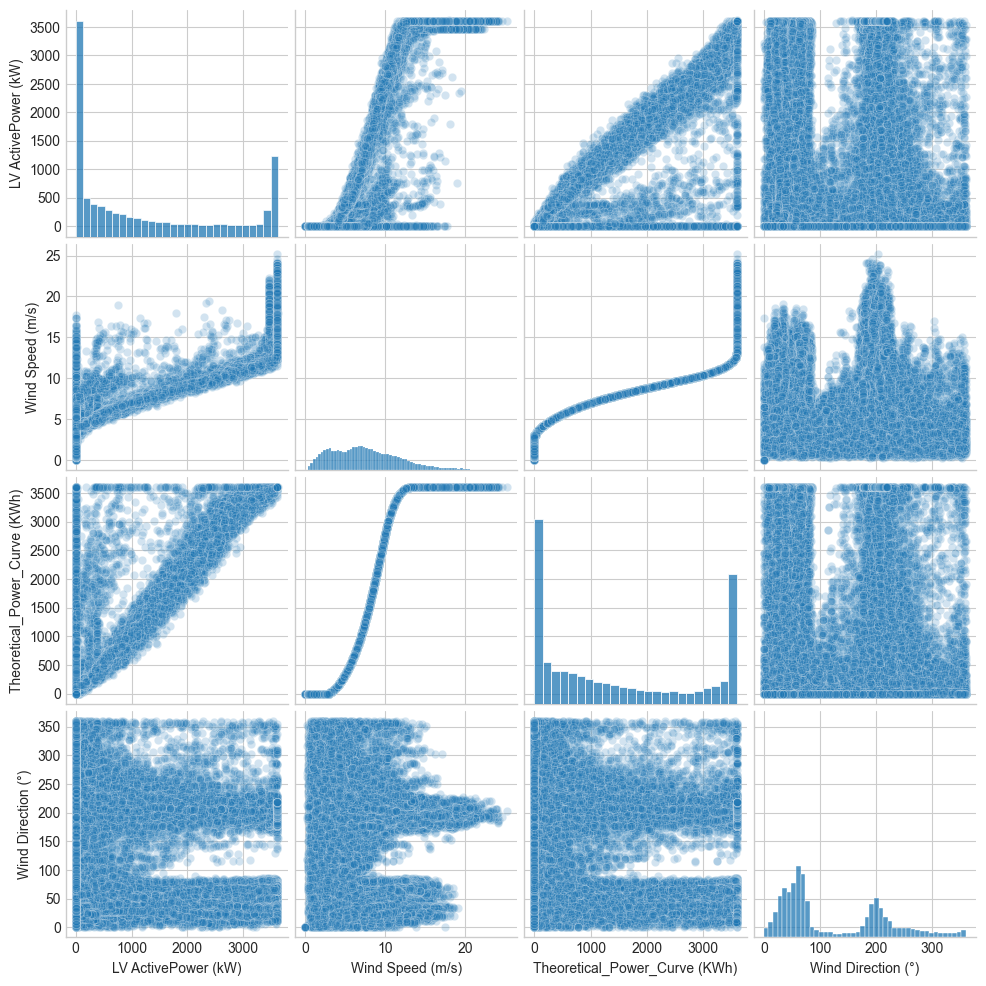

In [532]:
sns.pairplot(df[num_col],plot_kws={'alpha': 0.2})

* We can observe from the scatter plot between `Wind Speed` and `Theoretical Power Curve` that the wind turbine can not generate power when the wind is traveling bellow 4 m/s
* When the wind is blowing between 4 m/s and 11 m/s there is a linear growth in power and wind speed
* The generated power peaks at 3600 KWh when the wind speed passes 11 m/s

## Correlation

<Axes: >

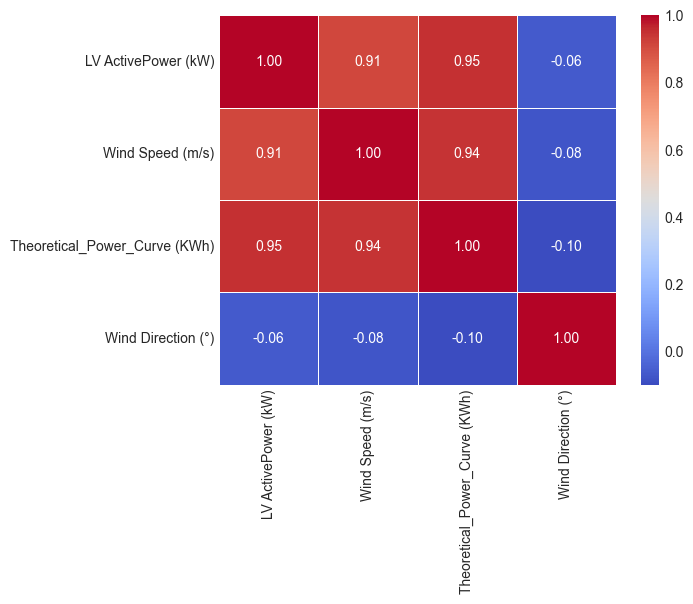

In [533]:
sns.heatmap(df[num_col].corr(), cmap="coolwarm",annot=True, fmt=".2f", linewidths=0.4)

## Circular Plot

### Visualizing Wind Direction

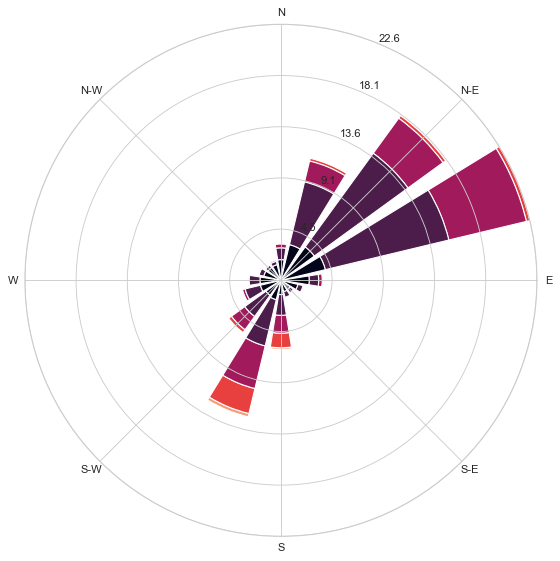

In [550]:
from windrose import WindroseAxes
ax = WindroseAxes.from_ax()
ax.bar(df['Wind Direction (°)'], df['Wind Speed (m/s)'], normed=True, opening=0.8, edgecolor='white')

## Time Plots

### Monthly Plots

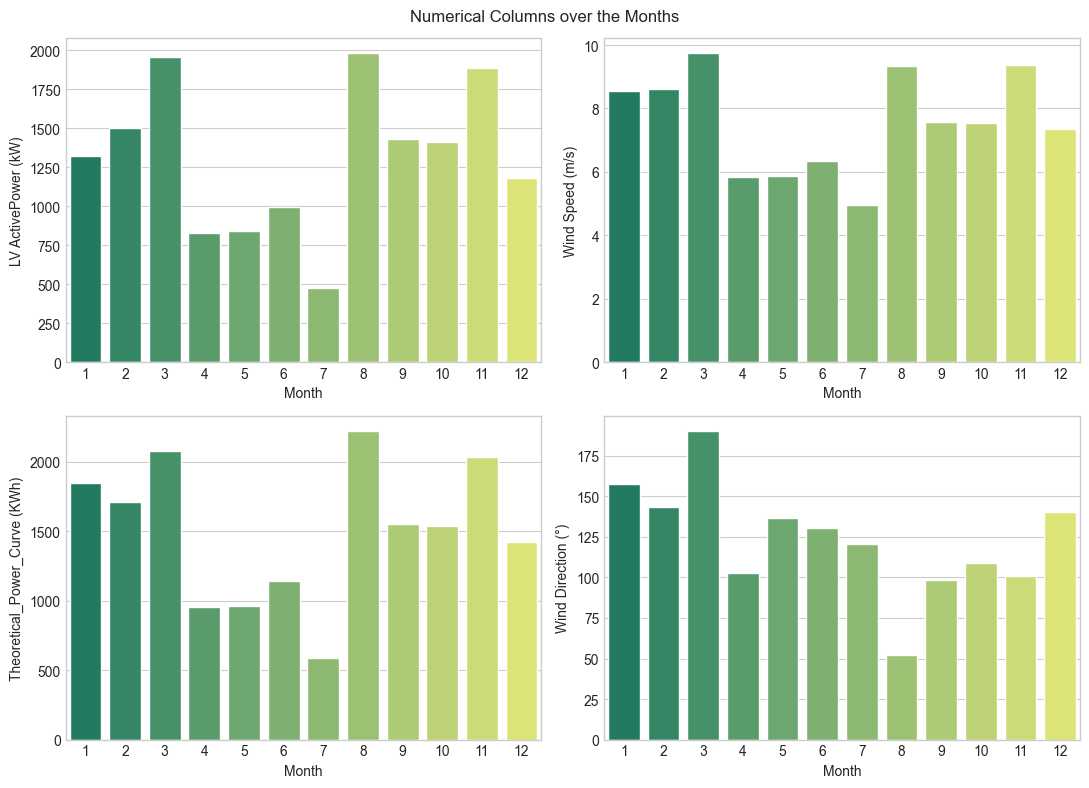

In [535]:
fig,axes=plt.subplots(nrows=len(num_col)//2 ,ncols=2,figsize=(11,8))
for idx,col in enumerate(df[num_col]):
    row_idx=idx//2
    col_idx=idx%2
    sns.barplot(x=df['Month'],y=df[col],data=df,ax=axes[row_idx,col_idx],errorbar=None,palette='summer')
fig.suptitle('Numerical Columns over the Months')
plt.tight_layout()
plt.show()

### Day/Night Plots

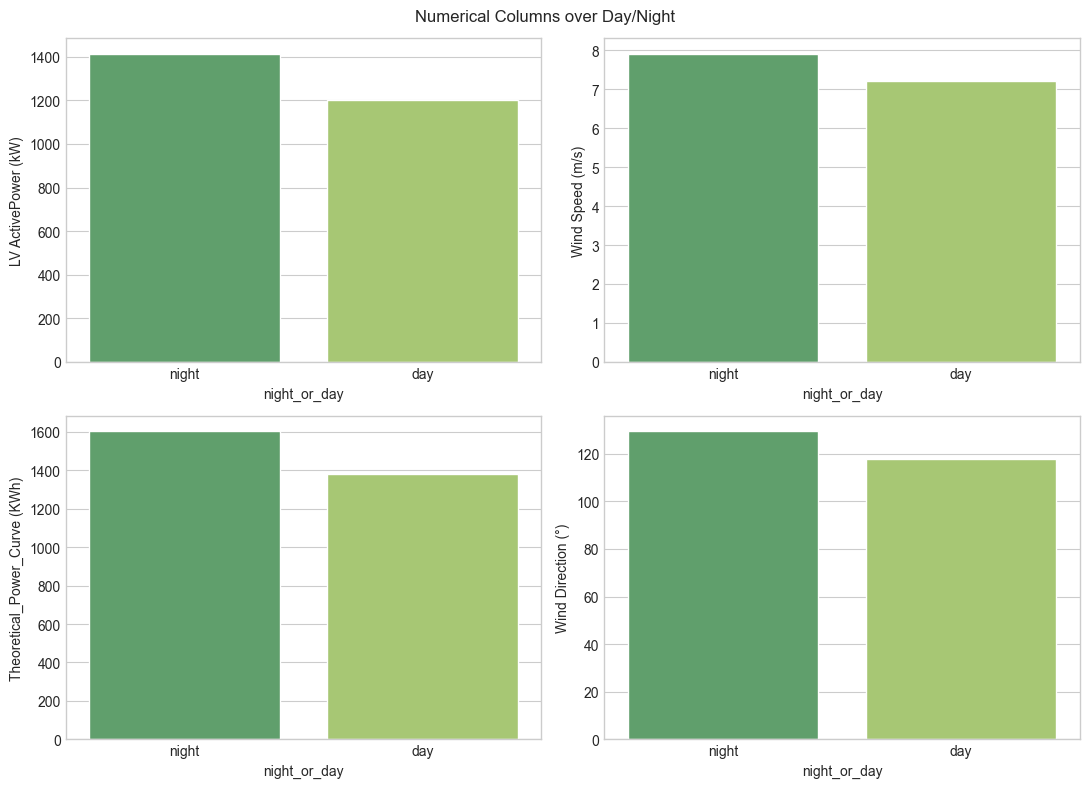

In [536]:
fig,axes=plt.subplots(nrows=len(num_col)//2 ,ncols=2,figsize=(11,8))
for idx,col in enumerate(df[num_col]):
    row_idx=idx//2
    col_idx=idx%2
    sns.barplot(x=df['night_or_day'],y=df[col],data=df,ax=axes[row_idx,col_idx],errorbar=None,palette='summer')
fig.suptitle('Numerical Columns over Day/Night')
plt.tight_layout()
plt.show()

### Seasonal Plots

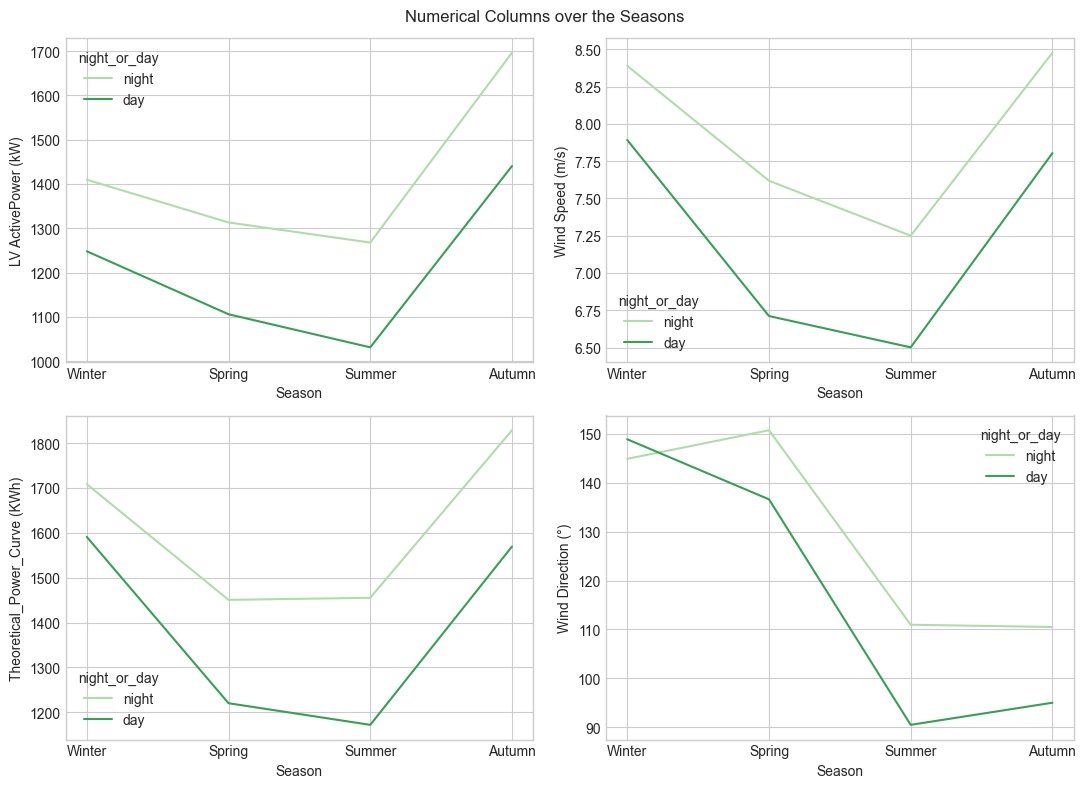

In [537]:
fig,axes=plt.subplots(nrows=len(num_col)//2 ,ncols=2,figsize=(11,8))
for idx,col in enumerate(df[num_col]):
    row_idx=idx//2
    col_idx=idx%2
    sns.lineplot(x='Season',y=df[col],data=df,ax=axes[row_idx,col_idx],ci=None, palette='Greens', hue='night_or_day')
fig.suptitle('Numerical Columns over the Seasons')
plt.tight_layout()
plt.show()

# Preprocessing

## Encoding

In [538]:
# One Hot Encoding Season Feature
df = pd.get_dummies(df, columns=['Season'], prefix='Season')

In [539]:
# Binary Encoding Night or Day Feature
df['is_day'] = df['night_or_day'].map({'day': 1, 'night': 0})

# Drop nigh_or_day feature
df.drop(columns=['night_or_day'], inplace=True)

## Data Splitting

In [540]:
X = df.drop(['LV ActivePower (kW)'], axis=1)
y = df['LV ActivePower (kW)']

Since this is time series data it is best practice to not randomly split and use time series split so the model does not have acess to future predictions

More info: https://medium.com/@Stan_DS/timeseries-split-with-sklearn-tips-8162c83612b9

In [541]:
tss = TimeSeriesSplit(n_splits = 5)

# Scores to actually use Cross Validation
time_split = [(train_index, test_index) for train_index, test_index in tss.split(X)]


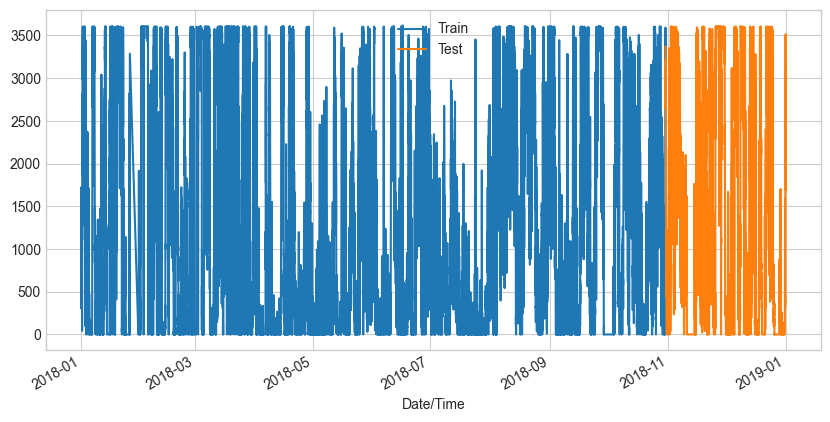

In [542]:
# Visualizing the last split
train_idx, test_idx = time_split[-1]

y_train_last_split = y.iloc[train_idx]
y_test_last_split = y.iloc[test_idx]

ax = y_train_last_split.groupby('Date/Time').mean().plot(label='Train', figsize=(10, 5))
y_test_last_split.groupby('Date/Time').mean().plot(ax=ax, label='Test')
ax.legend()

## Scaling

Since Wind direction is a directional and circular feature, we should handle it in a different way

In [584]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer

# Circular Transformation
def circular_scaling(X):
    X_arr = np.array(X)
    rad = np.deg2rad(X_arr)
    return np.column_stack([np.sin(rad), np.cos(rad)])

# Pipeline for Columns Transformation
preprocessor = ColumnTransformer(
    transformers=[
        ('std_scaler', StandardScaler(), ['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)']),
        ('custom_scaler', FunctionTransformer(circular_scaling), ['Wind Direction (°)'])
    ],
    remainder='passthrough'
)

In [557]:
preprocessor

,transformers,"[('std_scaler', ...), ('custom_scaler', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


# Modelling & Evaluation

In [545]:
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

## Linear Regression

In [562]:
model_lin = LinearRegression()

r2_scores = []
rmse_scores = []

# Time-Series Cross-Validation
for train_idx, test_idx in time_split:
    # Splitting data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Preprocessing
    # Fit and transform the training data
    X_train_processed = preprocessor.fit_transform(X_train)
    # Transform the test data
    X_test_processed = preprocessor.transform(X_test)

    # Training
    model_lin.fit(X_train_processed, y_train)

    # Prediction
    y_pred_lin = model_lin.predict(X_test_processed)

    # Evaluation
    r2_scores.append(r2_score(y_test, y_pred_lin))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_lin)))

# Results
print(f"Mean R2: {np.mean(r2_scores):.4f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f}")

Mean R2: 0.9106
Mean RMSE: 364.2486


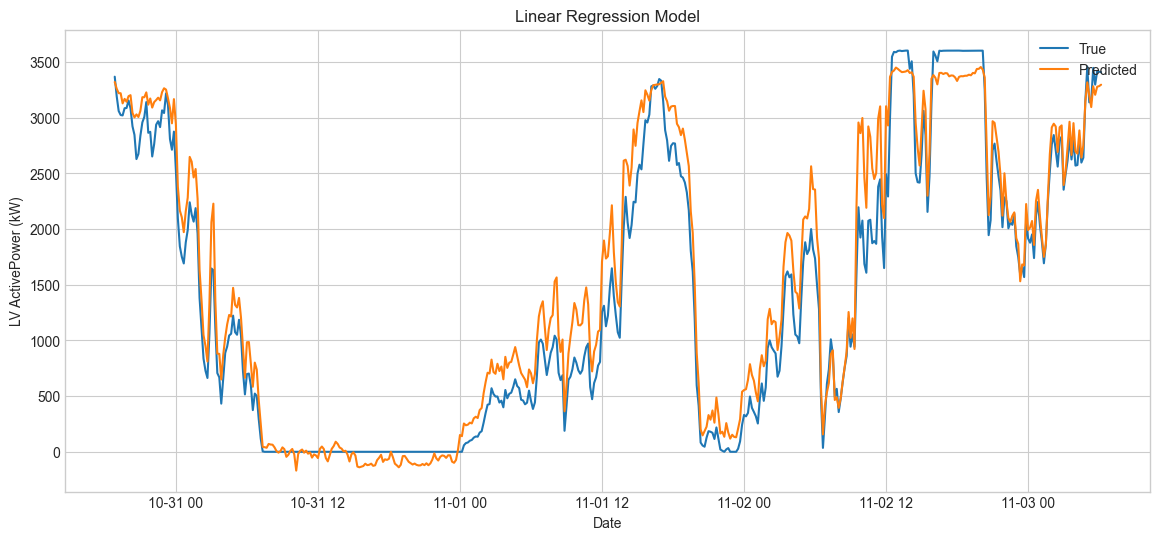

In [576]:
# line plot of observed vs predicted
sns.set_style("whitegrid")
plt.figure(figsize=(14,6))
sns.lineplot(y=y_test[0:500],x=y_test.index[0:500], label="True")
sns.lineplot(y=y_pred_lin[0:500],x=y_test.index[0:500], label="Predicted")
plt.legend(loc='upper right')
plt.title("Linear Regression Model")
plt.xlabel("Date / Time")
plt.ylabel("LV ActivePower (kW)")
plt.show()

## Random Forest Regressor

In [583]:
model_randF = RandomForestRegressor(n_estimators=100, random_state=42)

r2_scores = []
rmse_scores = []

# Time-Series Cross-Validation
for train_idx, test_idx in time_split:
    # Splitting data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Preprocessing
    # Fit and transform the training data
    X_train_processed = preprocessor.fit_transform(X_train)
    # Transform the test data
    X_test_processed = preprocessor.transform(X_test)

    # Training
    model_randF.fit(X_train_processed, y_train)

    # Prediction
    y_pred_randF = model_randF.predict(X_test_processed)

    # Evaluation
    r2_scores.append(r2_score(y_test, y_pred_randF))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_randF)))

# Results
print(f"Mean R2: {np.mean(r2_scores):.4f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f}")

Mean R2: 0.9195
Mean RMSE: 342.4424


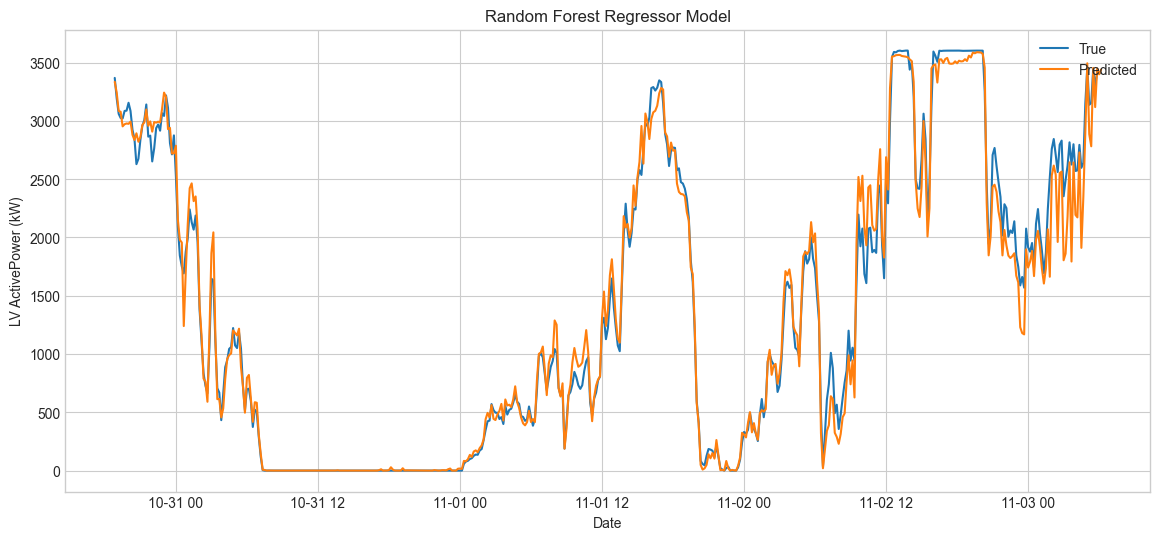

In [577]:
# line plot of observed vs predicted
sns.set_style("whitegrid")
plt.figure(figsize=(14,6))
sns.lineplot(y=y_test[0:500],x=y_test.index[0:500], label="True")
sns.lineplot(y=y_pred_randF[0:500],x=y_test.index[0:500], label="Predicted")
plt.legend(loc='upper right')
plt.title("Random Forest Regressor Model")
plt.xlabel("Date / Time")
plt.ylabel("LV ActivePower (kW)")
plt.show()